In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib.pyplot import imshow

In [2]:
# load data from data folder
training_data = datasets.ImageFolder(root='Data/train', transform=ToTensor())
test_data = datasets.ImageFolder(root='Data/test', transform=ToTensor())

In [3]:
# create data loaders
batch_size = 128
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break



Shape of X [N, C, H, W]: torch.Size([128, 3, 48, 48])
Shape of y: torch.Size([128]) torch.int64


In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(f"Using {device} device")

# Define model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (3, 48, 48)
            nn.Conv2d(
                in_channels=3,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 48, 48)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 112, 112)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 24, 24)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 24, 24)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 12, 12)
        )
        self.conv3 = nn.Sequential(         # input shape (32, 12, 12)
            nn.Conv2d(32, 64, 5, 1, 2),     # output shape (64, 12, 12)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (64, 6, 6)
        )


        self.dropout = nn.Dropout(p=0.5)

        self.out = nn.Linear(64 * 6 * 6, 7)   # 1 connected layer, output 25 classes


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 64 * 28 * 28)
        output = self.out(x)
        return output

model = CNN().to(device)
print(model)

Using cuda device
CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=2304, out_features=7, bias=True)
)


In [6]:
# Optimizing the model parameters
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
# Training the model
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
# Testing the model
def test(dataloader, model, loss_fn):
    test_accuracies = []
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100*correct)

#### Change Epochs

In [9]:
test_accuracies = []
# Training and testing the model
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    acc = test(test_dataloader, model, loss_fn)
    test_accuracies.append(acc)
print("Done!")

Epoch 1
-------------------------------
loss: 1.929655  [    0/28709]
loss: 0.092489  [12800/28709]
loss: 5.674089  [25600/28709]
Test Error: 
 Accuracy: 17.4%, Avg loss: 1.963865 

Epoch 2
-------------------------------
loss: 2.262753  [    0/28709]
loss: 0.994994  [12800/28709]
loss: 2.938353  [25600/28709]
Test Error: 
 Accuracy: 17.2%, Avg loss: 1.908918 

Epoch 3
-------------------------------
loss: 1.992429  [    0/28709]
loss: 1.703184  [12800/28709]
loss: 2.367054  [25600/28709]
Test Error: 
 Accuracy: 24.7%, Avg loss: 1.893737 

Epoch 4
-------------------------------
loss: 1.969034  [    0/28709]
loss: 1.881637  [12800/28709]
loss: 1.981582  [25600/28709]
Test Error: 
 Accuracy: 17.2%, Avg loss: 1.890786 

Epoch 5
-------------------------------
loss: 1.946090  [    0/28709]
loss: 1.827674  [12800/28709]
loss: 1.997723  [25600/28709]
Test Error: 
 Accuracy: 24.7%, Avg loss: 1.878135 

Epoch 6
-------------------------------
loss: 1.947940  [    0/28709]
loss: 1.779962  [128

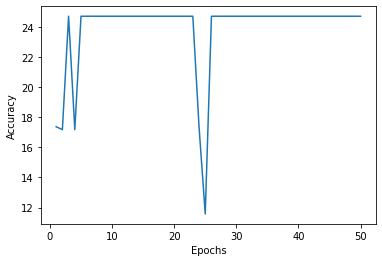

In [10]:
import matplotlib.pyplot as plt

x_axis = [i for i in range(1, epochs+1)]
plt.plot(x_axis, test_accuracies)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [11]:
# Save the model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth
